In [1]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt 
import random 
import math
import cmath
import scipy.interpolate

In [2]:
#density functions

def step_gaussian(x):
    if np.abs(x) <= 3:
        return np.exp(-0.5 * abs(x)**2)
    else:
        return 0

def gaussian(x):
    return np.exp(-0.5 * abs(x)**2)

def exponential(x):
    return np.exp(- abs(x))

def rect(x):
    if abs(x) > 1/2:
        return 0
    else:
        return 1
    
def strange_density(x):
    if abs(x) <= 0.08:
        return 0
    elif 0.08 <= abs(x) <= 0.16:
        return 2
    elif 0.16 <= abs(x) <= 0.32:
        return 1
    else:
        return 0 
    
def triangle(x):
    if  0 < x < 1:
        return 1 - x
    elif -1 < x <= 0:
        return 1 + x
    else:
        return 0
    
def semicircle(x):
    if abs(x) > 1:
        return 0
    else:
        return np.sqrt(1 - x**2)
    
def two_rects(x):
    if 0.08 <= abs(x) <= 0.16:
        return 1
    else:
        return 0
def bigger_rects(x):
    if 0.1 <= abs(x) <= 0.2:
        return 1
    else:
        return 0

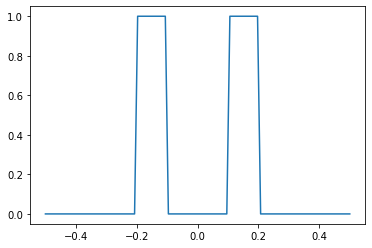

In [3]:
# draw_bigger_rects 
points = np.linspace(-0.5, 0.5, 100)
values = [bigger_rects(p) for p in points]
plt.plot(points, values)

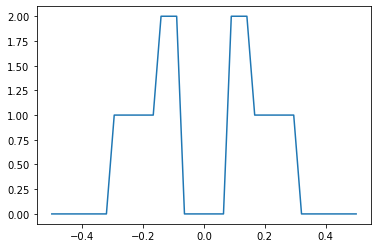

In [4]:
# draw strange_density
points = np.linspace(-0.5, 0.5, 40)
values = [strange_density(p) for p in points]
plt.plot(points, values)

# Solution 2
For details check https://faculty.washington.edu/dbp/PDFFILES/Interface-92-all.pdf

In [5]:
def U(sp_density, M):
    '''
    Auxiliary function for generate_GP
    params:
        sp_density: spectral density function
        M: right border of inerval [0, M]
    '''
    W = [random.gauss(0, 1) for i in range(M)]
    U = []
    U.append(math.sqrt(sp_density(0))* W[0])
    for j in range(1, int(M/2)):
        u = complex(W[2*j-1], W[2*j])
        U.append(math.sqrt(0.5 * sp_density(j/M)) * u)
        
    U.append(math.sqrt(0.5 * sp_density(0.5)) * W[M-1])
    
    for j in range(int(M/2) + 1, M):
        U.append(np.conjugate(U[M-j]))
    return U         

In [6]:
def generate_GP(sp_density, M, number_of_functions):
    '''
    Generate discrete realizations of a Gaussian process on interval [0, M] based on its density function.
    params:
        sp_density: spectral density function
        M: right border of inerval [0, M]
        number_of_functions: number of realizations to generate
    return: 
        Y: array of discrete realizations
    '''
    Uj = [U(sp_density, M) for i in range(number_of_functions)]
    Y = np.empty((number_of_functions, M))
    Y = [np.fft.fft(Uj[i])/np.sqrt(M) for i in range(number_of_functions)]
    for func in range(number_of_functions):
        Y[func] = [y.real for y in Y[func]]
    N = [i for i in range(M)]
    
    plt.figure(figsize=(15, 5), dpi=80)
    for func in range(number_of_functions):
        plt.plot(N, Y[func])
        
    plt.plot(N, np.zeros_like(N), color = 'green')     
    plt.show()  
    return Y

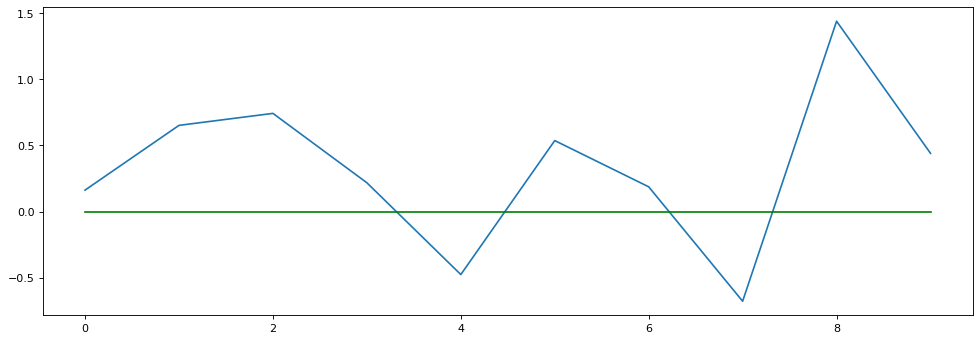

In [10]:
a = generate_GP(rect, 10, 1)

In [7]:
def built_density(kernel, M):
    '''
    Build 2 pictires:
       1. gaussian process according to a density function given on the interval [0, M]. 
       2. density obtained by applying fft to the constructed process.
       Density is considered on interval [-0.5 , 0.5]
    params: 
        kernel: density function 
        M: right border of interval [0, M]
    '''
    Y = generate_GP(kernel, M, 1)
    Q = np.fft.fft(Y[0])
    size = Q.shape[0]
    Q /= np.sqrt(size)
    N = [i/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    
    almost_density = np.log(np.abs(Q)**2 + 1e-20)
    true_density = [np.log(kernel(x)+1e-20) for x in N]
    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(N, almost_density)
    plt.plot(N, true_density)


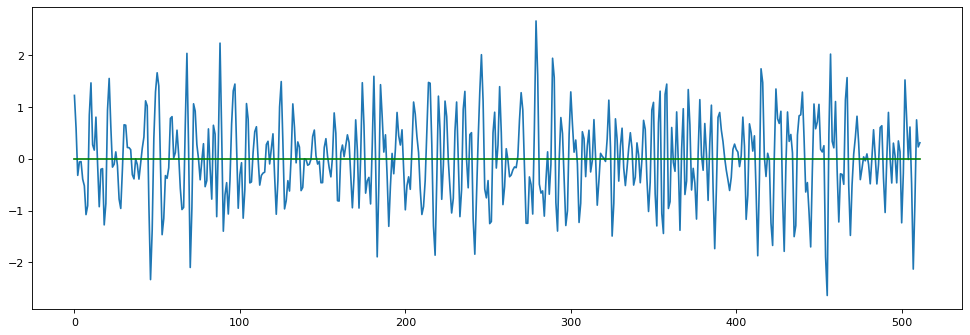

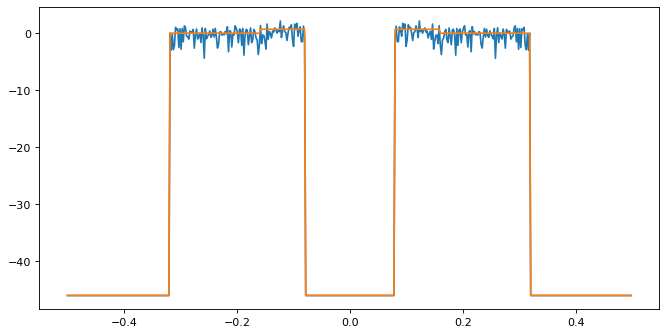

In [11]:
built_density(strange_density, 512)

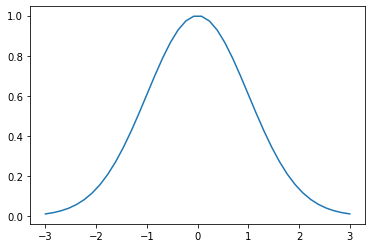

In [10]:
# draw gaussian density 
points = np.linspace(-3, 3, 40)
values = [gaussian(p) for p in points]
plt.plot(points, values)

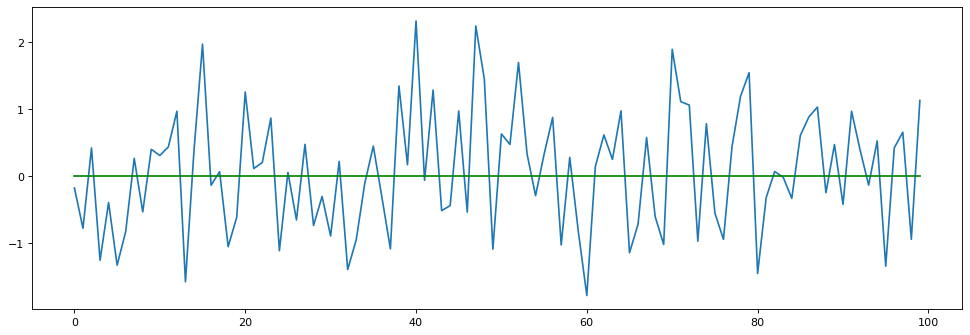

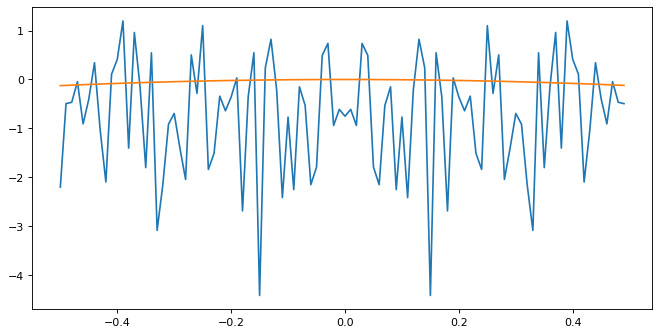

In [11]:
built_density(gaussian, 100)

# Solution 2 with scaling

In [8]:
# *2*scale/M
def U_scale(sp_density, M, scale):
    '''
    Auxiliary function for generate_GP
    params:
        sp_density: spectral density function
        M: right border of inerval [0, M]
        scale: factor of compressing density function
    '''
    W = [random.gauss(0, 1) for i in range(M)]
    U = []
    U.append(math.sqrt(sp_density(0))* W[0])
    for j in range(1, int(M/2)):
        u = complex(W[2*j-1], W[2*j])
        U.append(math.sqrt(0.5 * sp_density(scale*j/M)) * u)
    U.append(math.sqrt(0.5 * sp_density(scale*0.5)) * W[M-1])
    
    for j in range(int(M/2) + 1, M):
        U.append(np.conjugate(U[M-j]))
    return U       

In [9]:
def generate_GP_scale(dense, M, number_of_functions, scale, ls = True):
    '''
    Generate discrete realizations of a Gaussian process on interval [0, M] based on its density function.
    params:
        sp_density: spectral density function
        M: right border of inerval [0, M]
        number_of_functions: number of realizations to generate
        scale: factor of compressing density function
        ls: if True, build the plot
    return: 
        Y: array of discrete realizations
    '''
    Np = M*scale
    Uj = [U_scale(dense, Np, scale) for i in range(number_of_functions)]
    Y = np.empty((number_of_functions, Np))
    Y = [np.fft.fft(Uj[i])/np.sqrt(Np) for i in range(number_of_functions)]
    for func in range(number_of_functions):
        Y[func] = [y.real for y in Y[func]]
    N = [i/scale for i in range(Np)]
    if ls:
        fig = plt.figure(figsize=(15, 5), dpi=80)
        for func in range(number_of_functions):
            plt.plot(N, Y[func])

        plt.plot(N, np.zeros_like(N), color='green')    
        plt.show()     
    return Y

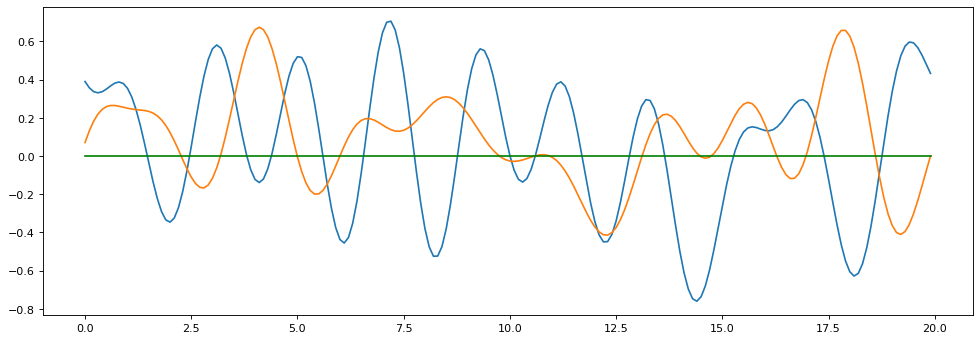

In [16]:
a = generate_GP_scale(rect, 20, 2, 10)

In [17]:
def built_density_scale(kernel, M, scale):
    '''
    Build 2 pictires:
       1. gaussian process according to a density function given on the interval [0, M]. 
       2. density obtained by applying fft to the constructed process.
       Density is considered on interval [-0.5 , 0.5]
    params: 
        kernel: density function 
        M: right border of interval [0, M]
        scale: factor of compressing density function
    '''
    built_density(lambda x: kernel(x*scale), M)


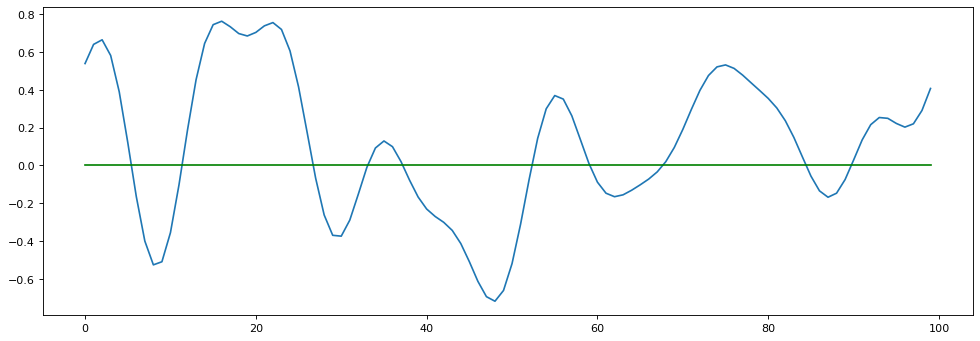

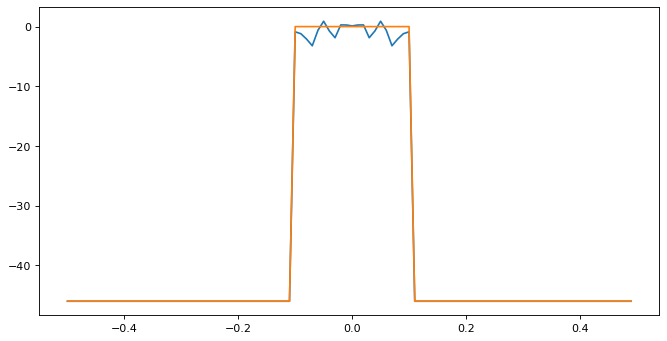

In [18]:
built_density_scale(rect, 100, 5)

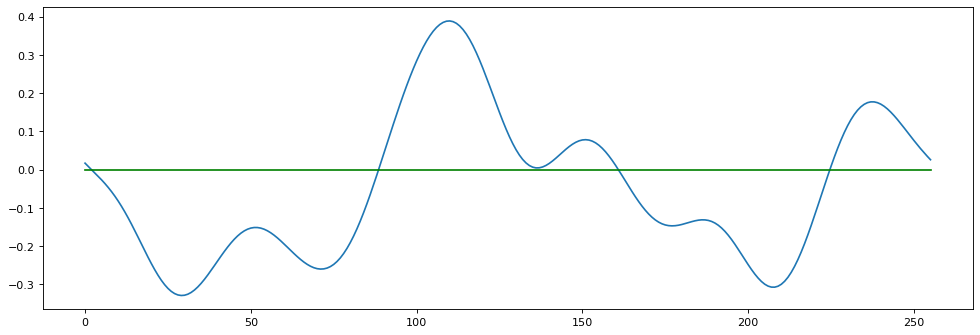

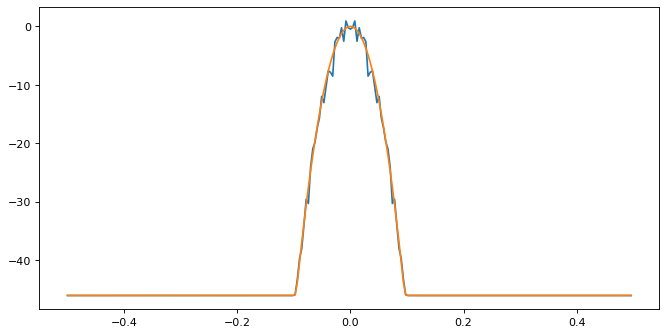

In [17]:
built_density_scale(gaussian, 256, 100)

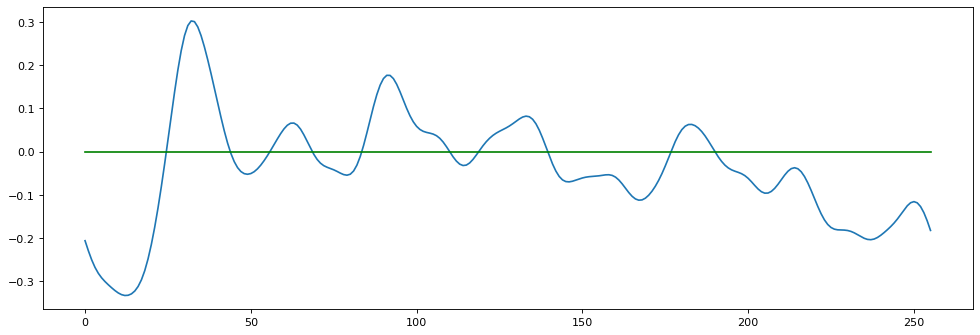

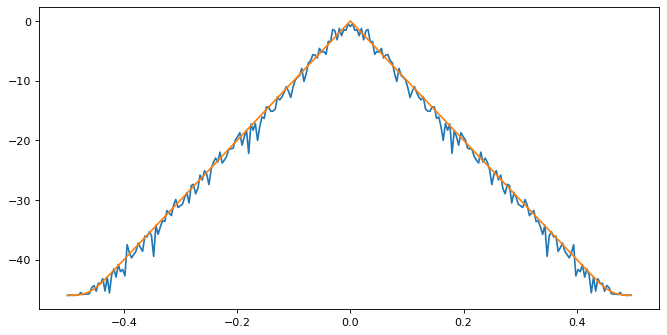

In [18]:
built_density_scale(exponential, 256, 100)

In [10]:
# comparison function
def cmp(a, b):
    if a > b:
        return 1
    elif a < b:
        return -1
    else:
        return 0

In [11]:
def integral(kernel, a = -7, b =7, n = 901):
    points = list(np.linspace(a, b, n)) # divide [-7, 7] onto 700 segments.
    points.pop(-1) # we will use values in the middle of each segment, so we erase the last point
    res = 0
    delta = (b-a)/(n-1)
    for point in points:
        res += kernel(point+delta/2)*delta # point+0.01 -- middle of the segment. 0.02 -- length of the segment
    return res

def prime_prime(kernel):
    f = lambda x: x* x * kernel(x)
    return -integral(f)

In [12]:
# check
print(integral(semicircle))
print(np.pi/2)

1.5704263771414726
1.5707963267948966


In [13]:
def intersections(kernel, M, number_of_functions, scale, ls = True, y = False, ls2 = False):
    zeros = np.zeros(number_of_functions)
    Y = np.array(generate_GP_scale(kernel, M, number_of_functions, scale, ls))
    size = Y.shape[1]
    for j in range(number_of_functions):
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0):
                zeros[j] += 1
    f = lambda x: kernel(x)             
    deriv = -prime_prime(f) # -second derivative
    alfa = 2*np.pi* np.sqrt(deriv/(integral(f) + 10e-8)) 
    E_zeros = 1/np.pi * alfa * M # count average amount of zeroes using Kac-Rice formula
    
    if ls:
        plt.figure(figsize = (10, 5), dpi=80)
    if ls2:
        plt.hist(zeros, edgecolor='white')
        print("E_zeros:", E_zeros) 
        
    if y:
        return zeros , E_zeros, Y
    else:
        return zeros , E_zeros

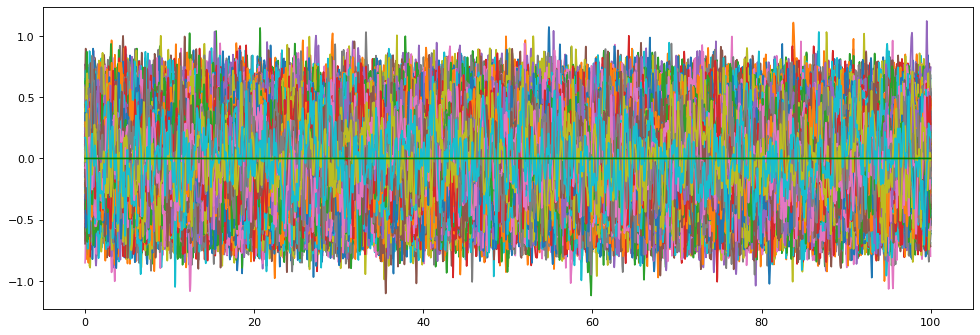

E_zeros: 278.74854706463424


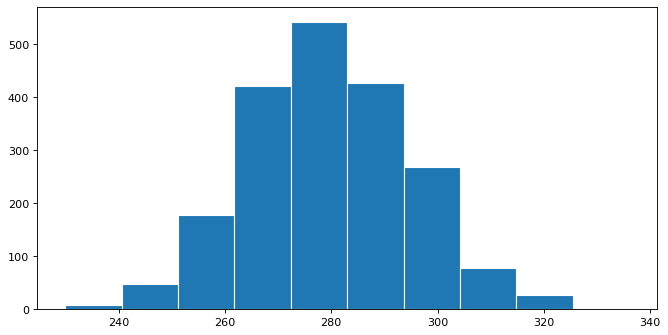

In [23]:
a = intersections(exponential, 100, 2000, 40)

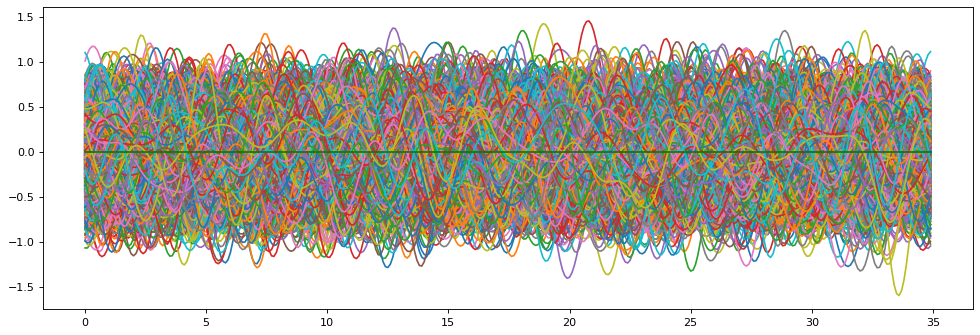

E_zeros: 20.114992476285945


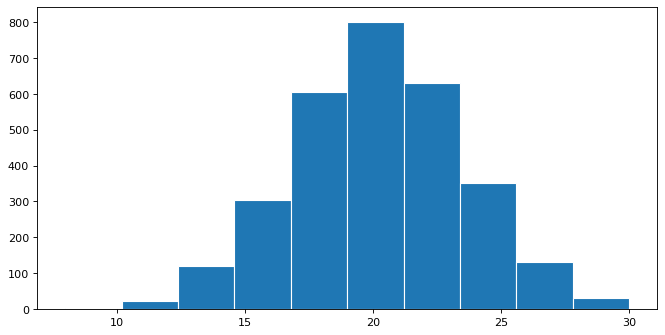

In [58]:
a = intersections(rect, 35, 3000, 10)

E_zeros: 23.744517402794088


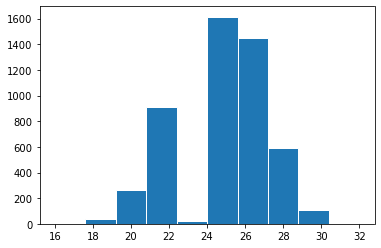

In [25]:
a = intersections(two_rects, 100, 5000, 15, ls = False, ls2 = True)

E_zeros: 23.744517402794088


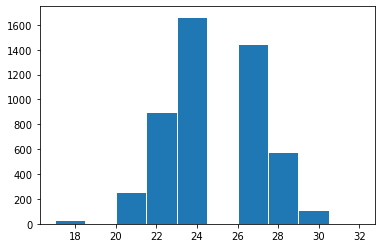

In [30]:
a = intersections(two_rects, 100, 5000, 25, ls = False, ls2 = True)

E_zeros: 47.489034805588176


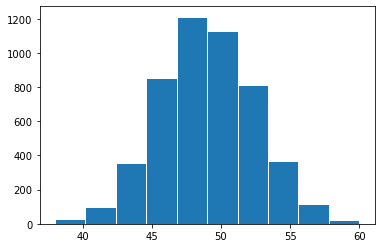

In [26]:
a = intersections(two_rects, 200, 5000, 15, ls = False, ls2 = True)

E_zeros: 47.489034805588176


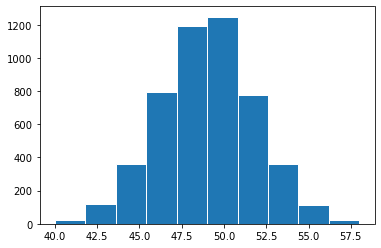

In [28]:
a = intersections(two_rects, 200, 5000, 20, ls = False, ls2 = True)

E_zeros: 78.41516008044019


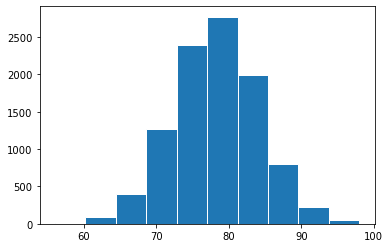

In [45]:
a = intersections(two_rects, 1000, 5000, 15, ls = False, ls2 = True)

E_zeros: 274.4530602815407


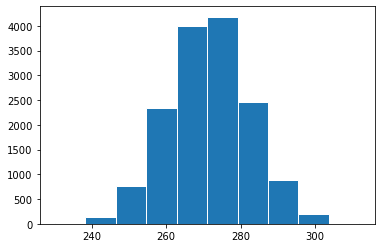

In [46]:
a = intersections(strange_density, 700, 15000, 20, ls = False, ls2 = True)

E_zeros: 39.207580040220094


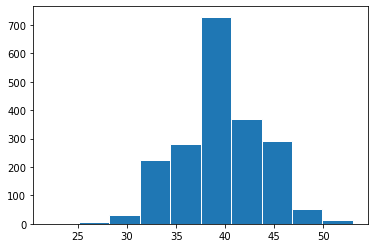

In [61]:
a = intersections(strange_density, 100, 2000, 5, ls = False, ls2 = True)

E_zeros: 50.57777825188393


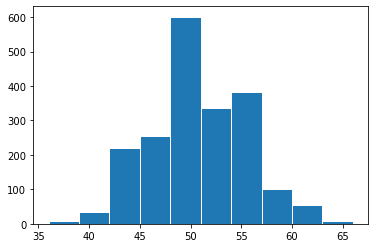

In [65]:
a = intersections(strange_density, 129, 2000, 10, ls = False, ls2 = True)

E_zeros: 50.969854052286124


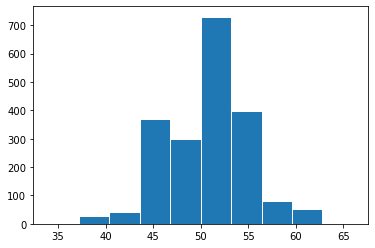

In [66]:
a = intersections(strange_density, 130, 2000, 15, ls = False, ls2 = True)

E_zeros: 78.41516008044019


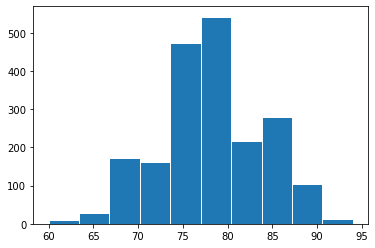

In [49]:
a = intersections(strange_density, 200, 2000, 15, ls = False, ls2 = True)

E_zeros: 78.41516008044019


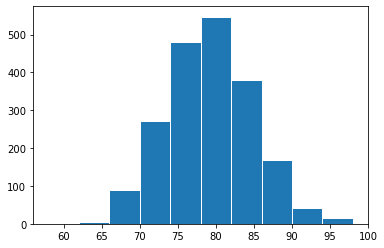

In [52]:
a = intersections(strange_density, 200, 2000, 10, ls = False, ls2 = True)

E_zeros: 50.969854052286124


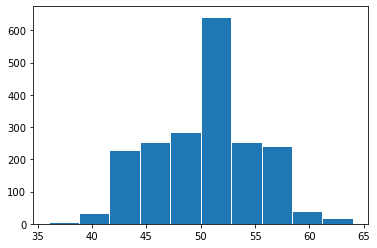

In [47]:
a = intersections(strange_density, 130, 2000, 20, ls = False, ls2 = True)

## Sanity check
Let us check that power spectrum bult using all the realizations is close to the real density:

[]

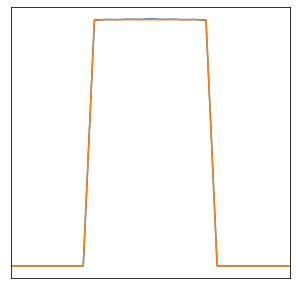

In [17]:
kernel = rect
e = 0.03
scale = 5
sup = 0.25
t = 10

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
zeros, E_zeros, Y = intersections(kernel, t, 200000 , scale, ls = False, y = True)
undercrowding = np.zeros(Y.shape[1])
Q = np.fft.fft(undercrowding)
Q = np.array([np.real(q) for q in Q])
#size = Q.shape[0]
count = 0
for z in range(len(zeros)):
    Q0 =  np.fft.fft(Y[z])
    Q0 = np.array([np.abs(q)**2 for q in Q0])
    size = Q0.shape[0]
    Q0 /= size 
    Q += Q0 
    count += 1
Q /= count# + 1e-30
#Q = np.array([np.real(q)**2 + np.imag(q)**2 for q in Q])
size = Q.shape[0] 
N = [i/size for i in range(-size//2, size//2)]
Q = np.hstack((Q[size//2:], Q[:size//2]))
almost_density = Q
true_density = [kernel(x*scale) for x in N]

ax.plot(N, almost_density)
ax.plot(N, true_density)
ax.set_xlim(-sup, sup)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])


## Building power spectrums

In [14]:
def under(kernel, scale, t, e, functions, figs = 5):
    fig, ax = plt.subplots(1, 1, figsize=(figs, figs))
    zeros, E_zeros, Y = intersections(kernel, t, functions , scale, ls = False, y = True)
    undercrowding = np.zeros(Y.shape[1])
    Q = np.fft.fft(undercrowding)
    Q = np.array([np.real(q) for q in Q])
    count = 0
    for z in range(len(zeros)):
        if E_zeros - zeros[z] > e*t:
            Q0 =  np.fft.fft(Y[z])
            Q0 = np.array([np.abs(q)**2 for q in Q0])
            size = Q0.shape[0]
            Q0 /= size 
            Q += Q0 
            count += 1
    Q /= count
    size = Q.shape[0] 
    N = [i/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    almost_density = Q
    true_density = [kernel(x*scale) for x in N]

    ax.plot(N, almost_density)
    ax.plot(N, true_density)
    ax.set_xlim(-1.25/scale, 1.25/scale)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

In [15]:
def over(kernel, scale, t, e, functions, figs = 5):
    fig, ax = plt.subplots(1, 1, figsize=(figs, figs))
    zeros, E_zeros, Y = intersections(kernel, t, functions , scale, ls = False, y = True)
    undercrowding = np.zeros(Y.shape[1])
    Q = np.fft.fft(undercrowding)
    Q = np.array([np.real(q) for q in Q])
    count = 0
    for z in range(len(zeros)):
        if E_zeros - zeros[z] < -e*t:
            Q0 =  np.fft.fft(Y[z])
            Q0 = np.array([np.abs(q)**2 for q in Q0])
            size = Q0.shape[0]
            Q0 /= size 
            Q += Q0 
            count += 1
    Q /= count
    size = Q.shape[0] 
    N = [i/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    almost_density = Q
    true_density = [kernel(x*scale) for x in N]

    ax.plot(N, almost_density)
    ax.plot(N, true_density)
    ax.set_xlim(-1.25/scale, 1.25/scale)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

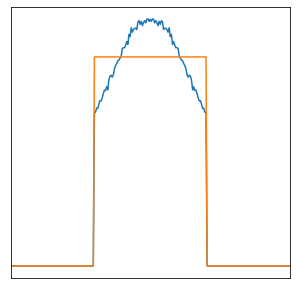

In [44]:
under(rect, 15, 100, 0.04, 50000)

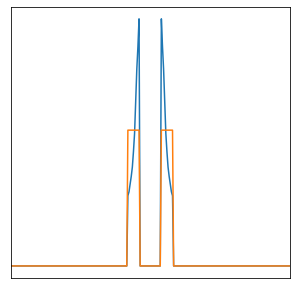

In [97]:
under(bigger_rects, 15, 100, 0.04, 50000)

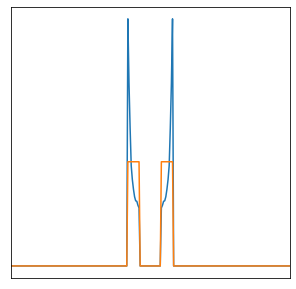

In [128]:
over(bigger_rects, 15, 100, 0.04, 50000)

In [ ]:
under(strange_density, 5, 100, 0.04, 50000)

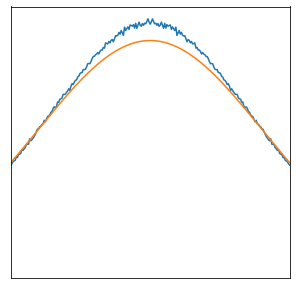

In [104]:
under(gaussian, 25, 100, 0.04, 50000)

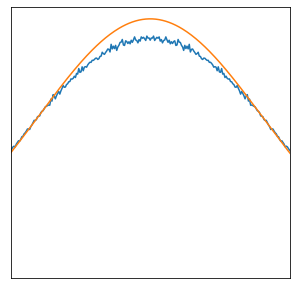

In [122]:
over(gaussian, 25, 100, 0.04, 50000)

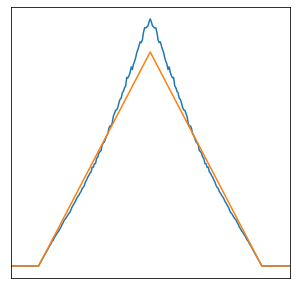

In [112]:
under(triangle, 30, 100, 0.04, 50000)

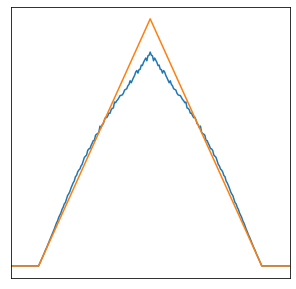

In [127]:
over(triangle, 30, 100, 0.04, 50000)

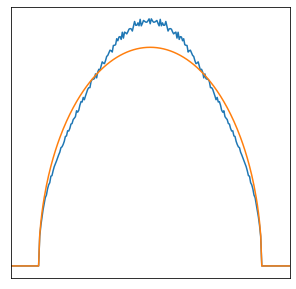

In [116]:
under(semicircle, 40, 100, 0.04, 50000)

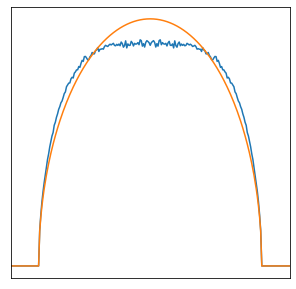

In [124]:
over(semicircle, 40, 100, 0.04, 50000)

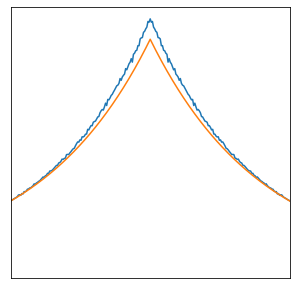

In [119]:
under(exponential, 40, 100, 0.04, 50000)

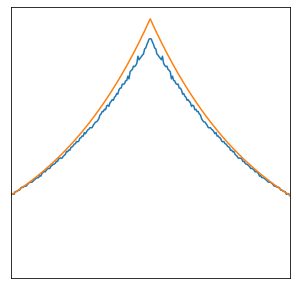

In [126]:
over(exponential, 40, 100, 0.04, 50000)

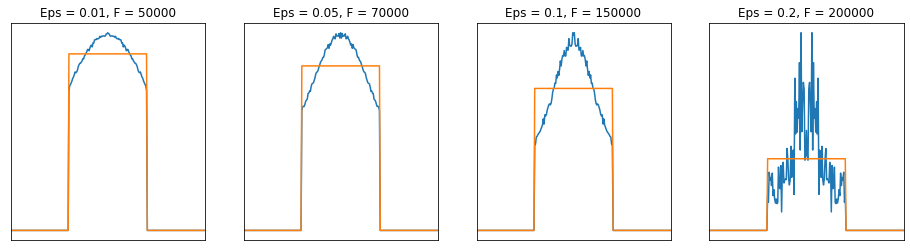

In [25]:
scale = 15
t = 100
Eps = [0.01, 0.05, 0.1, 0.2]
functions = [50000, 70000, 200000, 400000]
kernel = rect

fig, ax = plt.subplots(1, len(functions), figsize=(16,4))
for i, e in enumerate(Eps):
    zeros, E_zeros, Y = intersections(kernel, t, functions[i], scale, ls = False, y = True)
    undercrowding = np.zeros(Y.shape[1])
    Q = np.fft.fft(undercrowding)
    Q = np.array([np.real(q) for q in Q])
    count = 0
    for z in range(len(zeros)):
        if E_zeros - zeros[z] > e*t:
            Q0 =  np.fft.fft(Y[z])
            Q0 = np.array([np.abs(q)**2 for q in Q0])
            size = Q0.shape[0]
            Q0 /= size 
            Q += Q0 
            count += 1
    Q /= count
    size = Q.shape[0] 
    N = [i/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    almost_density = Q
    true_density = [kernel(x*scale) for x in N]

    ax[i].plot(N, almost_density)
    ax[i].plot(N, true_density)
    ax[i].set_xlim(-1.25/scale, 1.25/scale)
    ax[i].axes.xaxis.set_ticks([])
    ax[i].axes.yaxis.set_ticks([])
    ax[i].set_title(f'Eps = {e}, F = {functions[i]}')

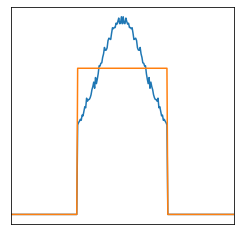

In [29]:
under(rect, 15, 100, 0.1, 200000, figs = 4)

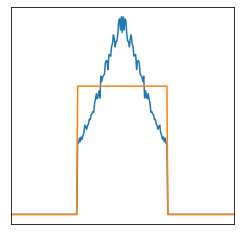

In [20]:
under(rect, 15, 100, 0.14, 310000, figs = 4)

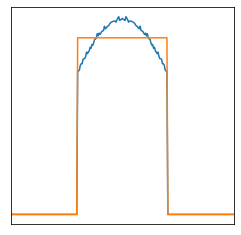

In [20]:
under(rect, 15, 100, 0.01, 50000, figs = 4)

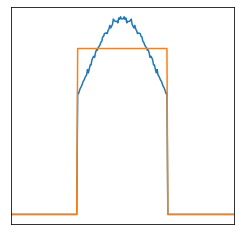

In [21]:
under(rect, 15, 100, 0.05, 70000, figs = 4)

In [25]:
from scipy.optimize import least_squares

In [26]:
def model(x, u):
    return u*u*x[0] + u*x[1] + x[2] # u -- points on x-axis аnd х is a coefficient vector: (a, b, c)

def fun(x, u, y):
    return model(x, u) - y  # y -- value of a power spectrum calculated by means of realizations with under/overcrowding
# we will minimize sum of squares of such functions over all u

# Jacobian
def Jac(x, u, y): 
    J = np.empty((u.size, x.size))
    J[:, 0] = u * u
    J[:, 1] = u
    J[:, 2] = 1
    return J



10854


NameError: name 'least_squares' is not defined

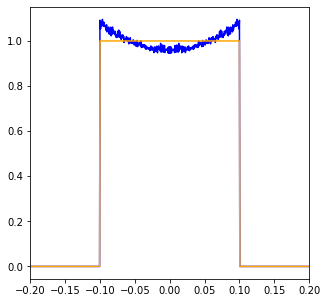

In [14]:
kernel = rect
Eps = [0.001, 0.005, 0.008, 0.015] # epsilon
T = [100, 500, 1000, 5000] # time intervals 
t = 400
e = 0.1
scale = 5
sup = 0.2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
zeros, E_zeros, Y = intersections(kernel, t, 20000 , scale, ls = False, y = True) # строю 1000 функций и считаю их нули 
undercrowding = np.zeros(Y.shape[1])
Q = np.fft.fft(undercrowding) # future power spectrum 
Q = np.array([np.real(q) for q in Q])
count = 0
for z in range(len(zeros)): # for each realization 
    if E_zeros - zeros[z] < -e*t: # if undercrowded, compute fft and add to power spectrum 
        Q0 =  np.fft.fft(Y[z])
        Q0 = np.array([np.abs(q)**2 for q in Q0])
        size = Q0.shape[0]
        Q0 /= size 
        Q += Q0 
        count += 1
Q /= count 
print(count)
size = Q.shape[0] 
N = [i/size for i in range(-size//2, size//2)]
Q = np.hstack((Q[size//2:], Q[:size//2])) # final power spectrum, blue curve
almost_density = Q
true_density = [kernel(x*scale) for x in N] # real spctrum, orange curve 

ax.plot(N, almost_density, color = 'blue') # draw final power spectrum
ax.plot(N, true_density, color = 'orange') # draw real spectrum
ax.set_xlim(-sup, sup) # cut axes for nice scale  

x0 = np.array([-1, 1, 1.2]) # initial values (a, b, c)
u = []
y = []
for i in range(len(N)):
    if (kernel(N[i]*scale)>0):
        u.append(N[i])
        y.append(almost_density[i])
u = np.array(u)
y = np.array(y)
res = least_squares(fun, x0, jac=Jac, args=(u, y), ) # compute (a, b, c)

u_test = np.linspace(-1/scale, 1/scale, 20)
y_test = model(res.x, u_test) # build parabola  
plt.plot(u_test, y_test)

In [194]:
print(f(-0.1), f(0.1))
print(f(-0.05), f(0.05))


0.8547942957527797 0.85479429575278
1.0771926774742662 1.0771926774742662


In [46]:
def draw(regime, kernel=rect, scale=5, T=[100, 400], Eps=[0.01, 0.05,], functions=25000, sup=0.2, quad = False):
    print(f'density = {kernel}, scale = {scale}')
    fig, axs = plt.subplots(len(Eps), len(T), figsize=(8, 8))
    tmp = scale
    if regime == 0:
        for i, e in enumerate(Eps):
            scale = tmp
            for j, t in enumerate(T):
                zeros, E_zeros, Y = intersections(kernel, t, functions + functions*j , scale, ls = False, y = True)
                undercrowding = np.zeros(Y.shape[1])
                Q = np.fft.fft(undercrowding)
                Q = np.array([np.real(q) for q in Q])
                count = 0
                for z in range(len(zeros)):
                    if E_zeros - zeros[z] > e*t:
                        Q0 =  np.fft.fft(Y[z])
                        Q0 = np.array([np.real(q)**2 + np.imag(q)**2 for q in Q0])
                        size = Q0.shape[0]
                        Q0 /= size 
                        Q += Q0 
                        count += 1
                Q /= count + 1e-30
                size = Q.shape[0] 
                N = [i/size for i in range(-size//2, size//2)]
                Q = np.hstack((Q[size//2:], Q[:size//2]))
                almost_density = Q
                true_density = [kernel(x*scale) for x in N]
                
                x0 = np.array([-1, 1, 1.2]) # initial values (a, b, c)
                u = []
                y = []
                for d in range(len(N)):
                    if (kernel(N[d]*scale)>0):
                        u.append(N[d])
                        y.append(almost_density[d])
                u = np.array(u)
                y = np.array(y)
                res = least_squares(fun, x0, jac=Jac, args=(u, y), ) # compute (a, b, c)

                u_test = np.linspace(-1/scale, 1/scale, 20)
                y_test = model(res.x, u_test) # build parabola 

                axs[i, j].plot(N, almost_density)
                axs[i, j].plot(N, true_density)
                if quad:
                    axs[i, j].plot(u_test, y_test)
                axs[i, j].set_xlim(-1.25/scale, 1.25/scale)
                axs[i, j].set_title(f'Eps = {e},T = {t}')
                
                scale = int(scale*(j+2)/(j+1))    

                        
    if  regime == 1:
        for i, e in enumerate(Eps):
            scale = tmp
            for j, t in enumerate(T):
                zeros, E_zeros, Y = intersections(kernel, t, functions + functions*j , scale, ls = False, y = True)
                overcrowding = np.zeros(Y.shape[1])
                Q = np.fft.fft(overcrowding)
                Q = np.array([np.real(q) for q in Q])
                #size = Q.shape[0]
                count = 0
                for z in range(len(zeros)):
                    if E_zeros - zeros[z] < -e*t:
                        Q0 =  np.fft.fft(Y[z])
                        Q0 = np.array([np.real(q)**2 + np.imag(q)**2 for q in Q0])
                        size = Q0.shape[0]
                        Q0 /= size 
                        Q += Q0 
                        count += 1
                Q /= count + 1e-30
                size = Q.shape[0] 
                N = [i/size for i in range(-size//2, size//2)]
                Q = np.hstack((Q[size//2:], Q[:size//2]))
                almost_density = Q
                true_density = [kernel(x*scale) for x in N]
                                
                x0 = np.array([-1, 1, 1.2]) # initial values (a, b, c)
                u = []
                y = []
                for d in range(len(N)):
                    if (kernel(N[d]*scale)>0):
                        u.append(N[d])
                        y.append(almost_density[d])
                u = np.array(u)
                y = np.array(y)
                res = least_squares(fun, x0, jac=Jac, args=(u, y), ) # compute (a, b, c)
                u_test = np.linspace(-1/scale, 1/scale, 20)
                y_test = model(res.x, u_test) # build parabola 

                axs[i, j].plot(N, almost_density)
                axs[i, j].plot(N, true_density)
                if quad:
                    axs[i, j].plot(u_test, y_test)
                axs[i, j].set_xlim(-1.25/scale, 1.25/scale)
                axs[i, j].set_title(f'Eps = {e},T = {t}')
                
                scale = int(scale*(j+2)/(j+1))

density = <function rect at 0x000002A9CBF1ADC0>, scale = 5


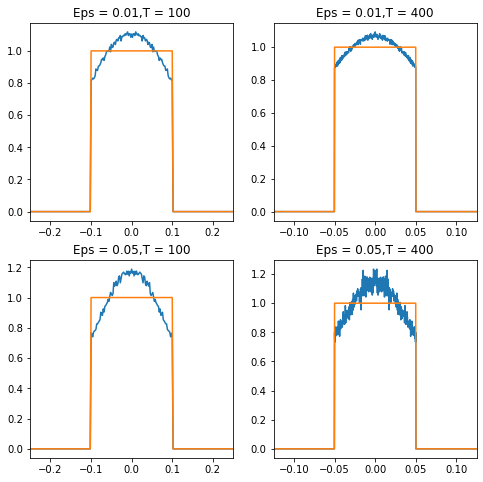

In [48]:
  draw(regime = 0, kernel = rect, scale = 5, )

density = <function rect at 0x000002A9CBF1ADC0>, scale = 5


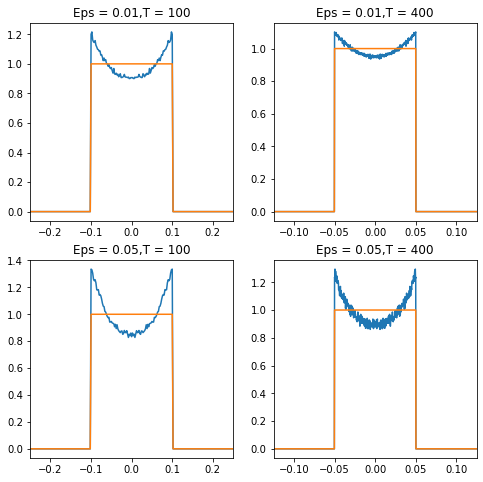

In [49]:
draw(regime = 1, kernel = rect, scale = 5)

density = <function bigger_rects at 0x000002A9CBF3F0D0>, scale = 5


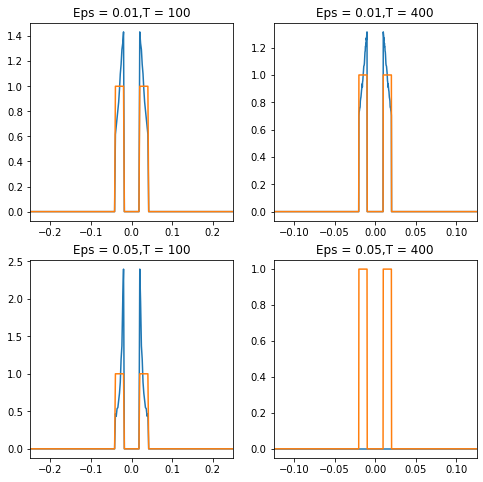

In [50]:
draw(regime = 0, kernel = bigger_rects)

density = <function bigger_rects at 0x000002A9CBF3F0D0>, scale = 5


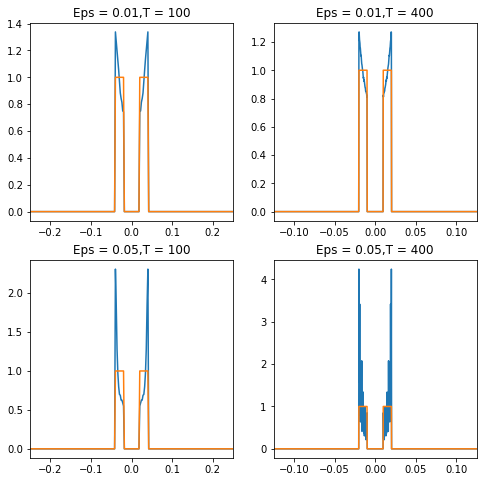

In [51]:
draw(regime = 1, kernel = bigger_rects)

density = <function triangle at 0x000002A9CBF1AEE0>, scale = 5


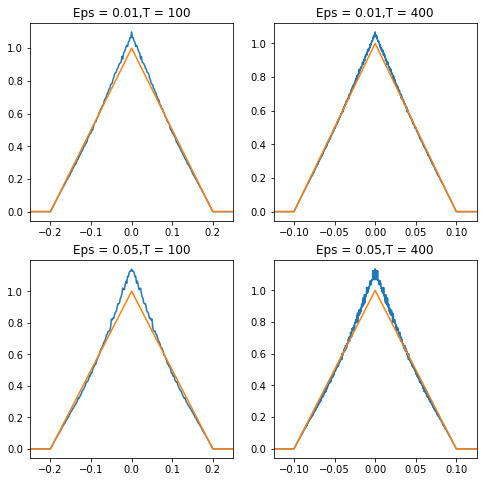

In [52]:
draw(regime = 0, kernel = triangle)

density = <function triangle at 0x000002A9CBF1AEE0>, scale = 5


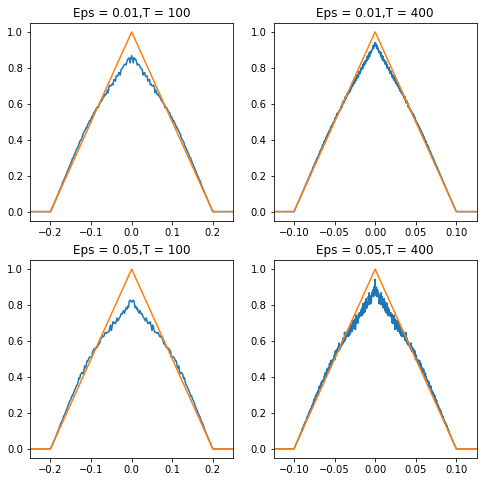

In [53]:
draw(regime = 1, kernel = triangle)

density = <function semicircle at 0x000002A9CBF1AF70>, scale = 5


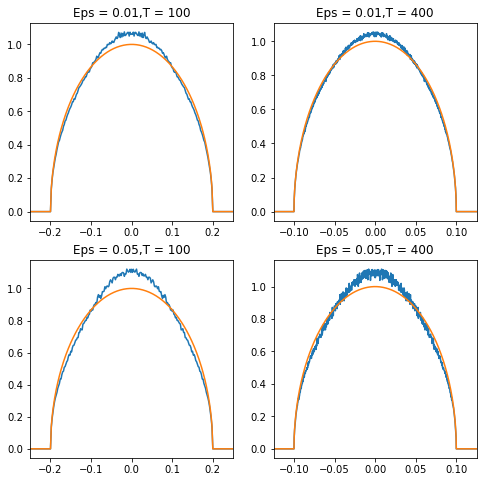

In [54]:
draw(regime = 0, kernel = semicircle)

density = <function semicircle at 0x000002A9CBF1AF70>, scale = 5


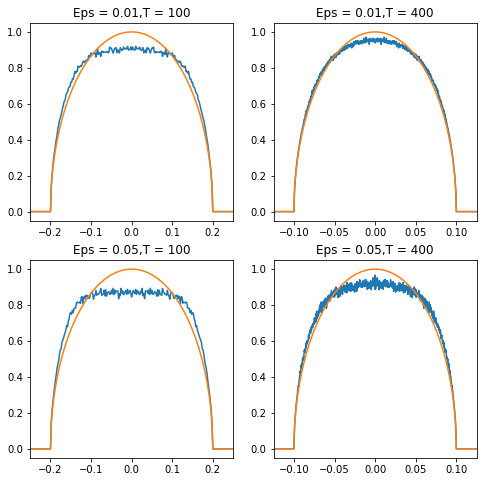

In [55]:
draw(regime = 1, kernel = semicircle)

density = <function exponential at 0x000002A9CBF1AD30>, scale = 5


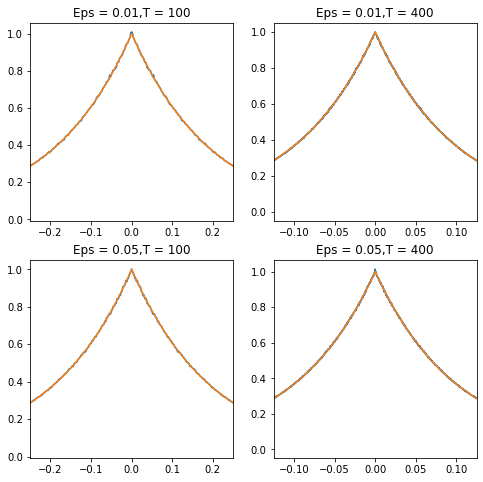

In [56]:
draw(regime = 0, kernel = exponential)

density = <function exponential at 0x000002A9CBF1AD30>, scale = 5


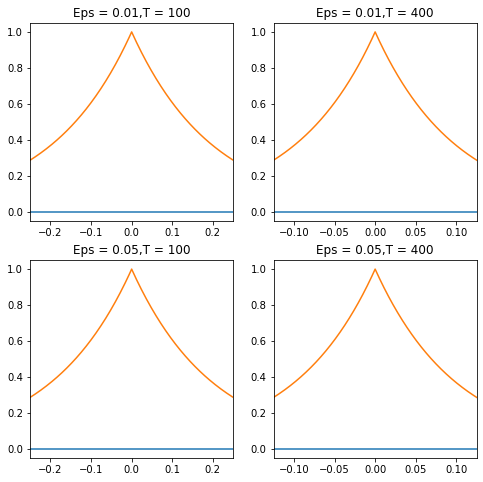

In [57]:
draw(regime = 1, kernel = exponential)

density = <function strange_density at 0x000002A9CBF1AE50>, scale = 5


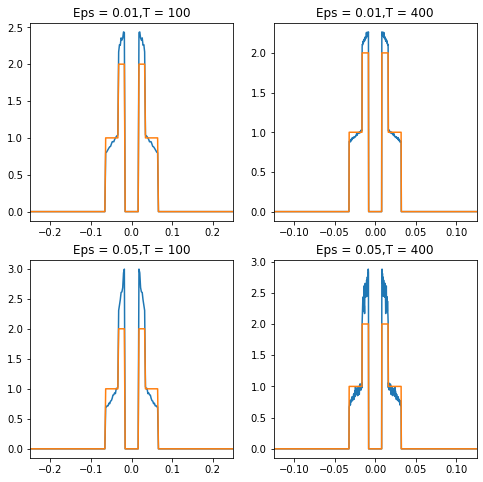

In [58]:
draw(regime = 0, kernel = strange_density)

density = <function strange_density at 0x000002A9CBF1AE50>, scale = 5


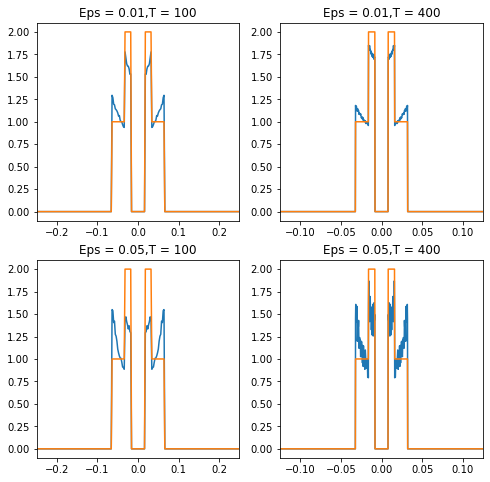

In [59]:
draw(regime = 1, kernel = strange_density)

density = <function gaussian at 0x000002A9CBF1ACA0>, scale = 5


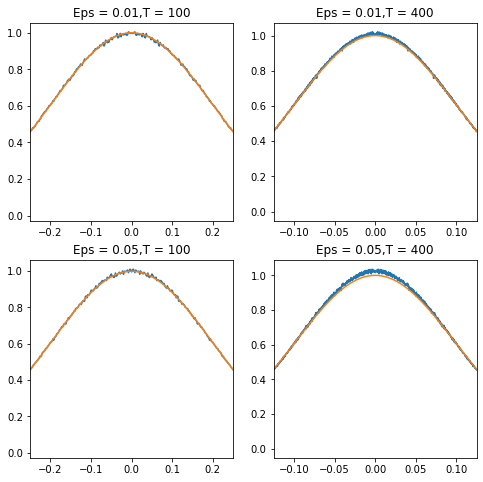

In [60]:
draw(regime = 0, kernel = gaussian)

density = <function gaussian at 0x000002A9CBF1ACA0>, scale = 5


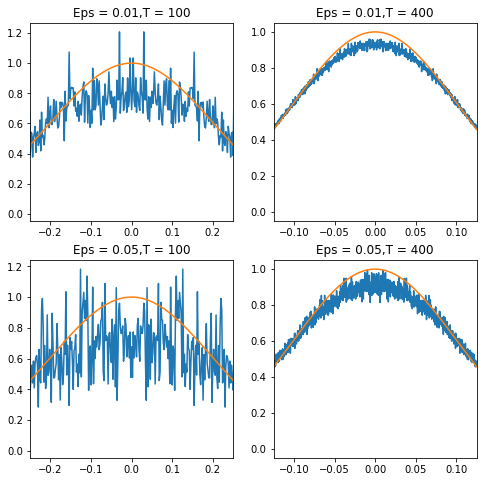

In [61]:
draw(regime = 1, kernel = gaussian)

In [ ]:
kernel = rect
Eps = [0.001, 0.005, 0.008, 0.015, 0.02] # epsilon
T = [100, 500, 1000, 5000] # time intervals 

scale = 5
fig, axs = plt.subplots(len(Eps), len(T), figsize=(20, 20))
for i, e in enumerate(Eps):
    
    for j, t in enumerate(T):
        zeros, E_zeros, Y = intersections(kernel, t, 3500 + 3000*j , scale, ls = False, y = True)
        overcrowding = np.zeros(Y.shape[1])
        Q = np.fft.fft(overcrowding)
        Q = np.array([np.real(q) for q in Q])
        size = Q.shape[0]
        count = 0
        for z in range(len(zeros)):
            if E_zeros - zeros[z] > e*t:
                Q0 =  np.fft.fft(Y[z])
                Q0 = np.array([np.abs(q)**2 for q in Q0])
                size = Q0.shape[0]
                Q0 /= size 
                Q += Q0
                count += 1
        Q /= count + 1e-30 
        N = [i/size for i in range(-size//2, size//2)]
        Q = np.hstack((Q[size//2:], Q[:size//2]))
        almost_density = Q
        true_density = [kernel(x*scale) for x in N]
         
        axs[i, j].plot(N, almost_density)
        axs[i, j].plot(N, true_density)
        axs[i, j].set_title(f'Eps = {e},T = {t}')        